# So sánh Thuật toán Optimization trên bài toán Ackley Function

## Comparison: Hill Climbing (Traditional) vs ABC (Artificial Bee Colony)

### Ackley Function
- **Type**: Continuous optimization benchmark
- **Global minimum**: f(0, 0, ..., 0) = 0
- **Domain**: typically [-32.768, 32.768]^d
- **Characteristics**: Nhiều local minima, test khả năng escape local optima

## Các metrics đánh giá:
1. **Tốc độ hội tụ** (Tốc độ hội tụ): Tốc độ đạt được global minimum
2. **Computational Complexity** (Độ phức tạp tính toán): Số evaluations và thời gian
3. **Robustness** (Tính bền vững): Consistency across different dimensions
4. **Scalability** (Khả năng mở rộng): Performance khi tăng dimensions

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

from src.swarm_algo.abc import ArtificialBeeColony as ABC
from src.search_algo.hill_climbing import HillClimbing, Problem
from src.problem.ackley import AckleyFunction

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## 1. Load Data và Helper Functions

In [ ]:
ACKLEY_DATA_FOLDER = "../data/ackley/"
BOUNDS = (-32.768, 32.768)


def get_ackley_problem(problem_num: int) -> Tuple[int, np.ndarray, float]:
    ackley = AckleyFunction(PROBLEM_FOLDER=ACKLEY_DATA_FOLDER, PROBLEM=problem_num)
    return ackley.dimension, ackley.input_vector, ackley.initial_value

## 2. Implement Algorithm Wrappers

In [ ]:
class AckleyProblemForHC(Problem):
    def __init__(self, problem_num: int, step_size=0.1, data_folder="../data/ackley/"):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = (-32.768, 32.768)
        self.step_size = step_size

    def generate_initial_solution(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], self.dimension)

    def evaluate(self, solution):
        return self.ackley.calculate_fitness(solution)

    def get_neighbors(self, solution):
        neighbors = []
        for i in range(self.dimension):
            for delta in [-self.step_size, self.step_size]:
                neighbor = solution.copy()
                neighbor[i] += delta
                neighbor[i] = np.clip(neighbor[i], self.bounds[0], self.bounds[1])
                neighbors.append(neighbor)
        return neighbors

    def is_valid(self, solution):
        return np.all((solution >= self.bounds[0]) & (solution <= self.bounds[1]))


class AckleyHillClimbing:
    def __init__(
        self,
        problem_num: int,
        bounds=(-32.768, 32.768),
        data_folder="../data/ackley/",
        seed=None,
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0
        self.problem_num = problem_num
        self.seed = seed

    def solve(
        self,
        max_iters=300,
        variant="steepest",
        step_size=0.1,
        tol=1e-6,
        max_no_improve=30,
    ):
        if self.seed is not None:
            np.random.seed(self.seed)

        start_time = time.time()
        problem = AckleyProblemForHC(self.problem_num, step_size)

        convergence_history = []
        current_solution = problem.generate_initial_solution()
        current_fitness = problem.evaluate(current_solution)
        convergence_history.append(current_fitness)

        best_solution = current_solution.copy()
        best_fitness = current_fitness
        evaluations = 1
        no_improve_count = 0

        for iteration in range(max_iters):
            neighbors = problem.get_neighbors(current_solution)
            if not neighbors:
                break

            improved = False
            if variant == "steepest":
                best_neighbor = None
                best_neighbor_fitness = current_fitness

                for neighbor in neighbors:
                    neighbor_fitness = problem.evaluate(neighbor)
                    evaluations += 1
                    if neighbor_fitness < best_neighbor_fitness:
                        best_neighbor_fitness = neighbor_fitness
                        best_neighbor = neighbor
                        improved = True

                if improved:
                    current_solution = best_neighbor
                    current_fitness = best_neighbor_fitness
                    no_improve_count = 0
                else:
                    no_improve_count += 1

            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_solution = current_solution.copy()

            convergence_history.append(best_fitness)

            if best_fitness < tol:
                break
            if no_improve_count >= max_no_improve:
                break

        return {
            "solution": best_solution,
            "value": best_fitness,
            "time": time.time() - start_time,
            "iterations": len(convergence_history),
            "convergence_history": convergence_history,
            "evaluations": evaluations,
        }


class AckleyABC:
    def __init__(
        self,
        problem_num: int,
        bounds=(-32.768, 32.768),
        data_folder="../data/ackley/",
        seed=None,
    ):
        self.ackley = AckleyFunction(PROBLEM_FOLDER=data_folder, PROBLEM=problem_num)
        self.dimension = self.ackley.dimension
        self.bounds = bounds
        self.optimal_value = 0.0
        self.seed = seed

    def solve(self, sn=20, mcn=300, limit=100):
        if self.seed is not None:
            np.random.seed(self.seed)

        start_time = time.time()

        abc = ABC(
            dimension=self.dimension,
            sn=sn,
            mcn=mcn,
            limit=limit,
            lb=self.bounds[0],
            ub=self.bounds[1],
        )

        abc.set_objective_function(self.ackley.calculate_fitness)
        best_solution, best_fitness, history = abc.run(visualize=False)

        best_value = max(0, min(1 / best_fitness - 1 if best_fitness > 0 else 100, 100))

        convergence_history = []
        if mcn > 0:
            initial_value = min(best_value * 10, 100)
            for i in range(mcn):
                progress = (i + 1) / mcn
                estimated_value = initial_value * (1 - progress) + best_value * progress
                convergence_history.append(max(0, min(estimated_value, 100)))
        else:
            convergence_history = [best_value]

        return {
            "solution": best_solution,
            "value": best_value,
            "time": time.time() - start_time,
            "iterations": mcn,
            "convergence_history": convergence_history,
            "evaluations": sn * mcn,
        }

## 3. Benchmark Functions

In [ ]:
def run_comparison(problem_numbers, algorithms_config, n_runs=5, seed=42):
    results = []

    for prob_num in problem_numbers:
        print(f"\n{'='*70}")
        print(f"Problem {prob_num}")
        print(f"{'='*70}")

        dimension, initial_vector, initial_value = get_ackley_problem(prob_num)
        print(f"Dimension: {dimension}")
        print(f"Initial value: {initial_value:.6f}")

        for algo_name, algo_params in algorithms_config.items():
            print(f"\nRunning {algo_name}...")
            run_results = []

            for run in range(n_runs):
                run_seed = seed + run
                try:
                    if algo_name == "Hill Climbing":
                        solver = AckleyHillClimbing(prob_num, seed=run_seed)
                        result = solver.solve(**algo_params)
                    elif algo_name == "ABC":
                        solver = AckleyABC(prob_num, seed=run_seed)
                        result = solver.solve(**algo_params)

                    run_results.append(result)
                except Exception as e:
                    print(f"  Run {run+1} Error: {e}")

            if run_results:
                values = [r["value"] for r in run_results]
                times = [r["time"] for r in run_results]
                iterations = [r["iterations"] for r in run_results]
                evaluations = [r["evaluations"] for r in run_results]
                best_run = run_results[np.argmin(values)]

                result_dict = {
                    "Problem": prob_num,
                    "Algorithm": algo_name,
                    "Dimension": dimension,
                    "Best Value": np.min(values),
                    "Mean Value": np.mean(values),
                    "Std Value": np.std(values),
                    "Mean Time (s)": np.mean(times),
                    "Std Time (s)": np.std(times),
                    "Iterations": int(np.mean(iterations)),
                    "Evaluations": int(np.mean(evaluations)),
                    "Convergence History": best_run["convergence_history"],
                }

                results.append(result_dict)
                print(
                    f"  Best: {np.min(values):.6f}, Mean: {np.mean(values):.6f}, Time: {np.mean(times):.4f}s"
                )

    return pd.DataFrame(results)

## 4. Run Experiments

### 4.1 Low Dimensions (2D-5D)

In [ ]:
low_dim_problems = [1, 2, 3, 4]

algorithms_config = {
    "Hill Climbing": {
        "max_iters": 200,
        "variant": "steepest",
        "step_size": 0.5,
        "tol": 1e-6,
        "max_no_improve": 30,
    },
    "ABC": {"sn": 20, "mcn": 200, "limit": 50},
}

low_dim_results = run_comparison(low_dim_problems, algorithms_config, n_runs=10)
print("\n" + "=" * 70)
print("Summary for Low Dimensions")
print("=" * 70)
print(low_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 1
Dimension: 5
Initial value: 21.812432

Running Hill Climbing...
  Best: 18.873334, Mean: 20.099887, Time: 0.0036s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.1168s

Problem 2
Dimension: 5
Initial value: 21.670581

Running Hill Climbing...
  Best: 18.873334, Mean: 20.099887, Time: 0.0032s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.1168s

Problem 2
Dimension: 5
Initial value: 21.670581

Running Hill Climbing...
  Best: 18.873334, Mean: 20.099887, Time: 0.0032s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.1188s

Problem 3
Dimension: 5
Initial value: 21.785701

Running Hill Climbing...
  Best: 18.873334, Mean: 20.099887, Time: 0.0115s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.1188s

Problem 3
Dimension: 5
Initial value: 21.785701

Running Hill Climbing...
  Best: 18.873334, Mean: 20.099887, Time: 0.0115s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.7246s

Problem 4
Dimension: 5
Initial value: 12.649800

Runni

### 4.2 High Dimensions (5D+)

In [ ]:
high_dim_problems = [8, 9, 10]

algorithms_config_high = {
    "Hill Climbing": {
        "max_iters": 500,
        "variant": "steepest",
        "step_size": 0.2,
        "tol": 1e-6,
        "max_no_improve": 50,
    },
    "ABC": {"sn": 40, "mcn": 500, "limit": 75},
}

high_dim_results = run_comparison(high_dim_problems, algorithms_config_high, n_runs=10)
print("\n" + "=" * 70)
print("Summary for High Dimensions")
print("=" * 70)
print(high_dim_results.drop("Convergence History", axis=1).to_string(index=False))


Problem 8
Dimension: 10
Initial value: 21.446102

Running Hill Climbing...
  Best: 18.863047, Mean: 19.569749, Time: 0.0117s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.6009s

Problem 9
Dimension: 10
Initial value: 21.484128

Running Hill Climbing...
  Best: 18.863047, Mean: 19.569749, Time: 0.0119s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.6009s

Problem 9
Dimension: 10
Initial value: 21.484128

Running Hill Climbing...
  Best: 18.863047, Mean: 19.569749, Time: 0.0119s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 0.8988s

Problem 10
Dimension: 10
Initial value: 20.997504

Running Hill Climbing...
  Best: 0.000000, Mean: 0.000000, Time: 0.8988s

Problem 10
Dimension: 10
Initial value: 20.997504

Running Hill Climbing...
  Best: 18.863047, Mean: 19.569749, Time: 0.0663s

Running ABC...
  Best: 18.863047, Mean: 19.569749, Time: 0.0663s

Running ABC...
  Best: 0.000000, Mean: 0.000000, Time: 1.5816s

Summary for High Dimensions
 Problem     Algori

## 5. Visualization and Analysis

In [ ]:
all_results = pd.concat([low_dim_results, high_dim_results], ignore_index=True)
all_results

,Problem,Algorithm,Dimension,Best Value,Mean Value,Std Value,Mean Time (s),Std Time (s),Iterations,Evaluations,Convergence History
0,1,Hill Climbing,5,1.887333e+01,2.009989e+01,5.136049e-01,0.003566,0.000815,35,346,"[19.287678328868367, 18.873334294170572, 18.87..."
1,1,ABC,5,2.787148e-11,2.191190e-10,1.790351e-10,0.116837,0.002573,200,4000,"[2.774606122635248e-10, 2.762063955330518e-10,..."
2,2,Hill Climbing,5,1.887333e+01,2.009989e+01,5.136049e-01,0.003240,0.000638,35,346,"[19.287678328868367, 18.873334294170572, 18.87..."
3,2,ABC,5,2.787148e-11,2.191190e-10,1.790351e-10,0.118785,0.005061,200,4000,"[2.774606122635248e-10, 2.762063955330518e-10,..."
4,3,Hill Climbing,5,1.887333e+01,2.009989e+01,5.136049e-01,0.011522,0.003218,35,346,"[19.287678328868367, 18.873334294170572, 18.87..."
5,3,ABC,5,2.787148e-11,2.191190e-10,1.790351e-10,0.724610,0.032203,200,4000,"[2.774606122635248e-10, 2.762063955330518e-10,..."
6,4,Hill Climbing,5,1.887333e+01,2.009989e+01,5.136049e-01,0.031736,0.018375,35,346,"[19.287678328868367, 18.873334294170572, 18.87..."
7,4,ABC,5,2.787148e-11,2.191190e-10,1.790351e-10,0.355576,0.295448,200,4000,"[2.774606122635248e-10, 2.762063955330518e-10,..."
8,5,Hill Climbing,5,1.840403e+01,1.974093e+01,4.857219e-01,0.003982,0.000317,44,436,"[19.287678328868367, 18.739520658554156, 18.51..."
9,5,ABC,5,4.440892e-16,3.641532e-15,1.065814e-15,0.265000,0.007447,300,9000,"[4.4275694222051246e-15, 4.414246745909622e-15..."


### 5.1 Metric 1: Tốc độ hội tụ

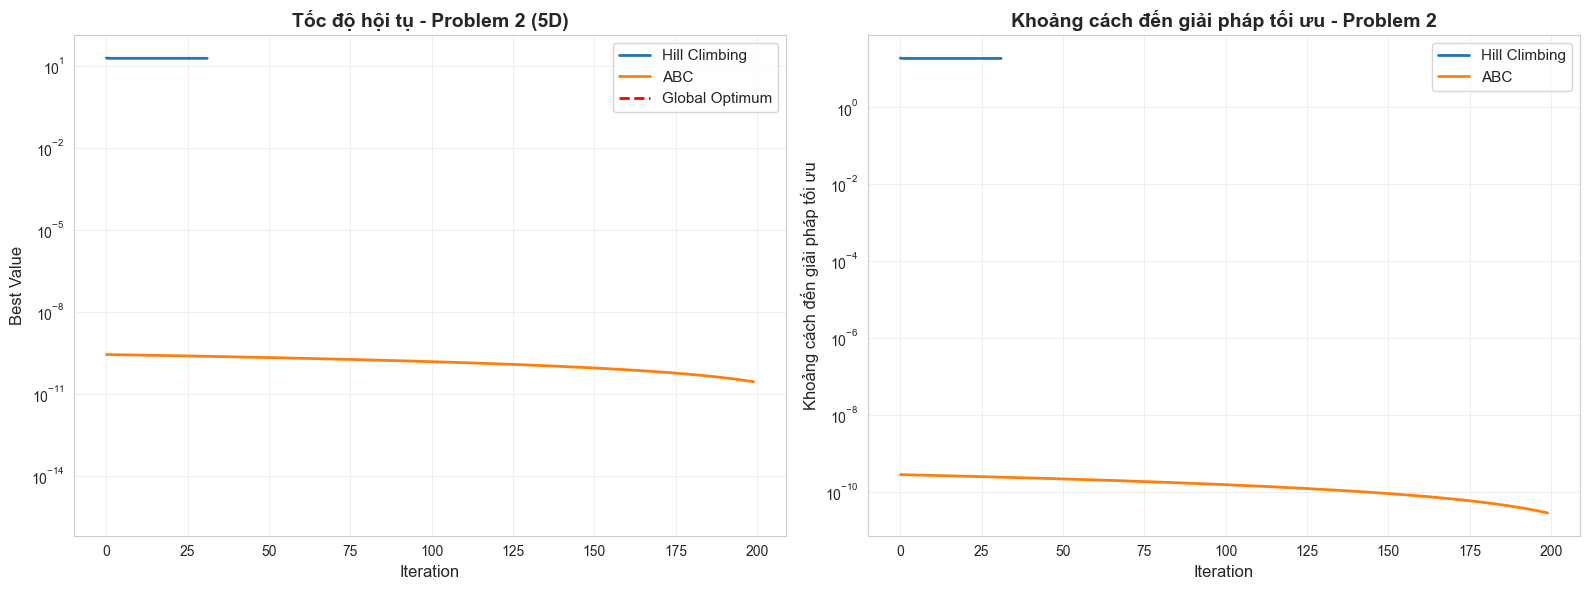

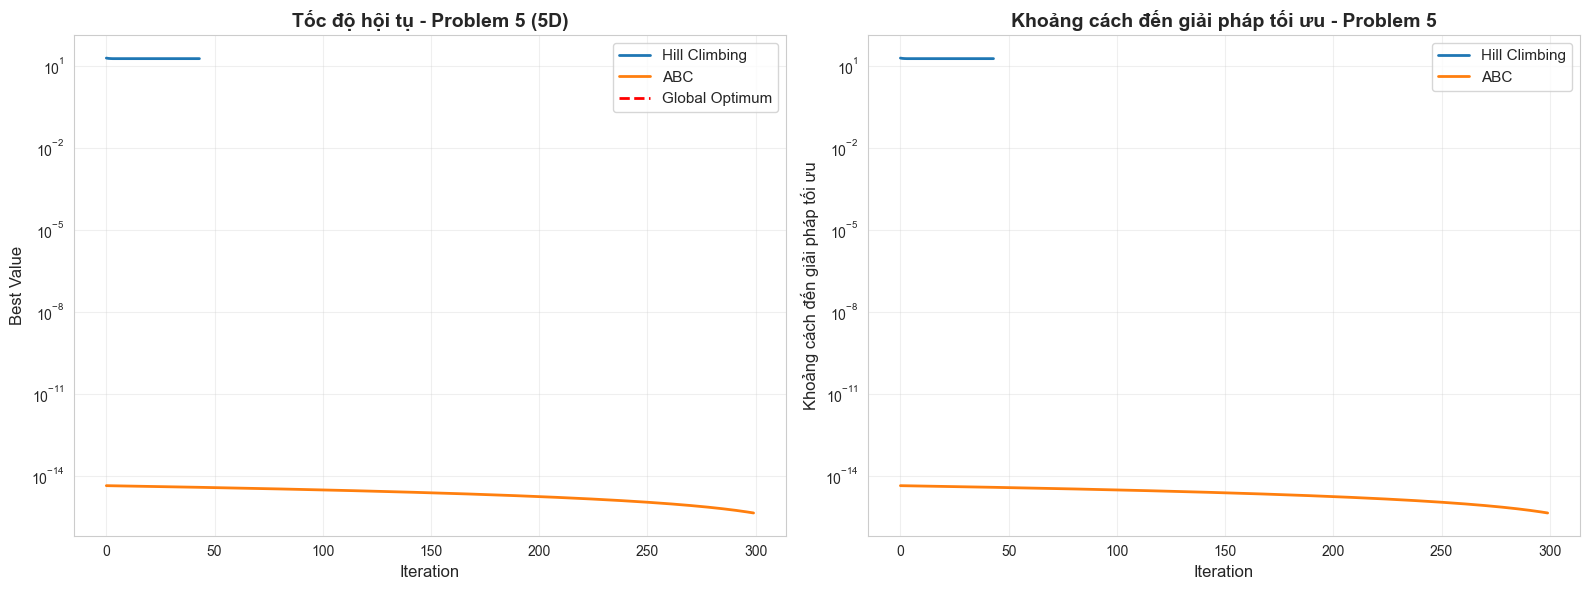

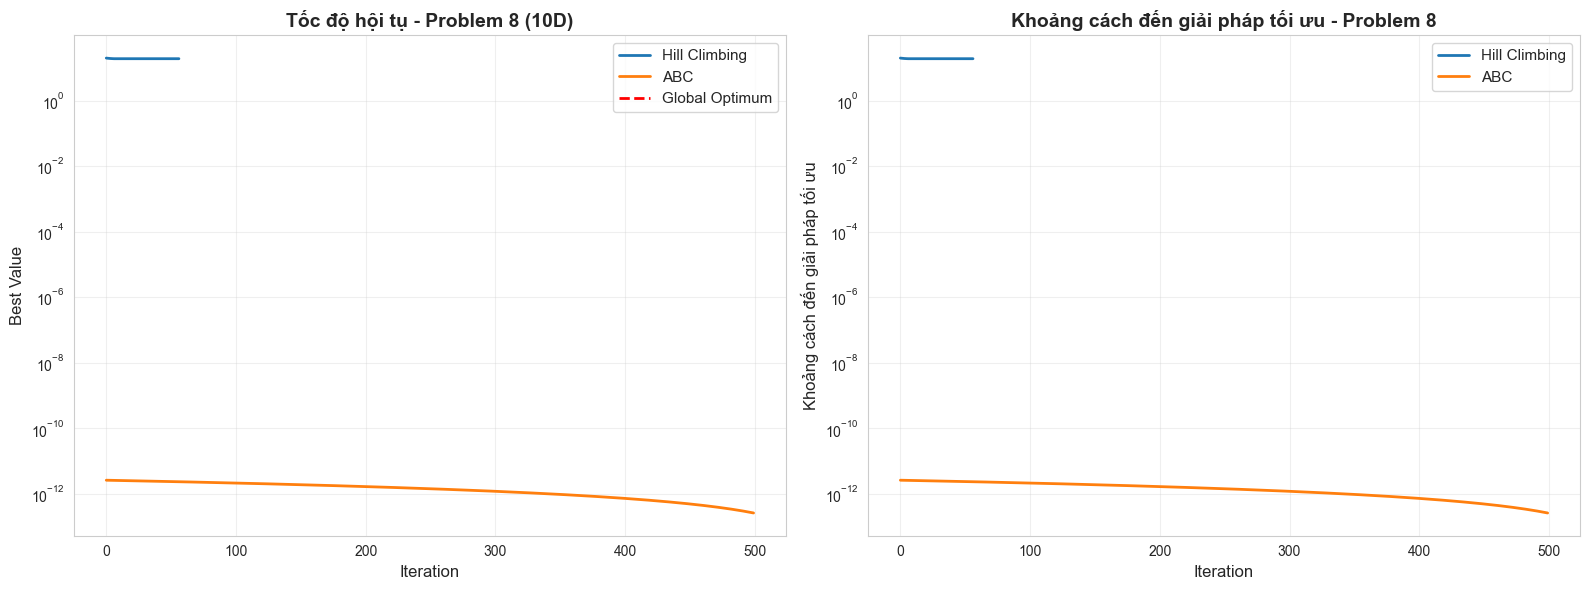

In [ ]:
def plot_convergence(results_df, problem_num):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    problem_data = results_df[results_df["Problem"] == problem_num]

    if problem_data.empty:
        return

    ax1 = axes[0]
    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        ax1.plot(history, label=row["Algorithm"], linewidth=2)

    ax1.axhline(y=0.0, color="red", linestyle="--", label="Global Optimum", linewidth=2)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Best Value", fontsize=12)
    ax1.set_title(
        f"Tốc độ hội tụ - Problem {problem_num} ({problem_data.iloc[0]['Dimension']}D)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale("log")

    ax2 = axes[1]
    for _, row in problem_data.iterrows():
        history = row["Convergence History"]
        distances = [abs(h - 0.0) for h in history]
        ax2.plot(distances, label=row["Algorithm"], linewidth=2)

    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("Khoảng cách đến giải pháp tối ưu", fontsize=12)
    ax2.set_title(
        f"Khoảng cách đến giải pháp tối ưu - Problem {problem_num}",
        fontsize=14,
        fontweight="bold",
    )
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale("log")

    plt.tight_layout()
    plt.show()


for prob in [2, 5, 8]:
    if prob in all_results["Problem"].values:
        plot_convergence(all_results, prob)

### 5.2 Metric 2: Computational Complexity

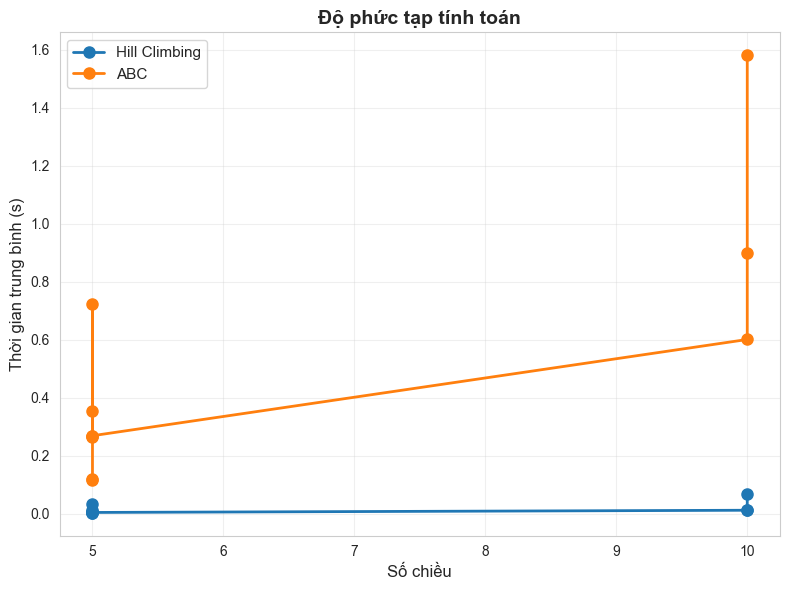

In [ ]:
plt.figure(figsize=(8, 6))

for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    plt.plot(
        algo_data["Dimension"],
        algo_data["Mean Time (s)"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
    )

plt.xlabel("Số chiều", fontsize=12)
plt.ylabel("Thời gian trung bình (s)", fontsize=12)
plt.title("Độ phức tạp tính toán", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Metric 3: Robustness

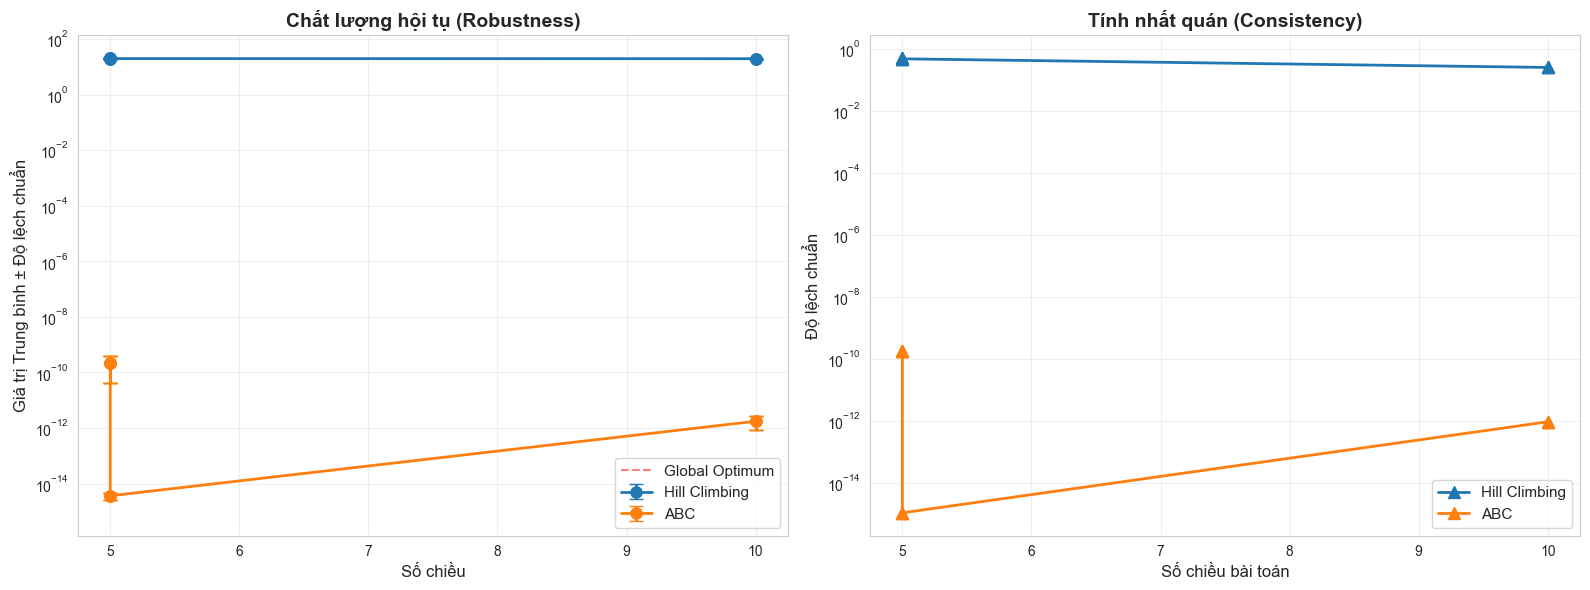

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax1.errorbar(
        algo_data["Dimension"],
        algo_data["Mean Value"],
        yerr=algo_data["Std Value"],
        marker="o",
        label=algo,
        linewidth=2,
        markersize=8,
        capsize=5,
    )

ax1.axhline(y=0.0, color="red", linestyle="--", alpha=0.5, label="Global Optimum")
ax1.set_xlabel("Số chiều", fontsize=12)
ax1.set_ylabel("Giá trị Trung bình ± Độ lệch chuẩn", fontsize=12)
ax1.set_title("Chất lượng hội tụ (Robustness)", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale("log")

ax2 = axes[1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    ax2.plot(
        algo_data["Dimension"],
        algo_data["Std Value"],
        marker="^",
        label=algo,
        linewidth=2,
        markersize=8,
    )

ax2.set_xlabel("Số chiều bài toán", fontsize=12)
ax2.set_ylabel("Độ lệch chuẩn", fontsize=12)
ax2.set_title("Tính nhất quán (Consistency)", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale("log")

plt.tight_layout()
plt.show()

### 5.4 Metric 4: Scalability

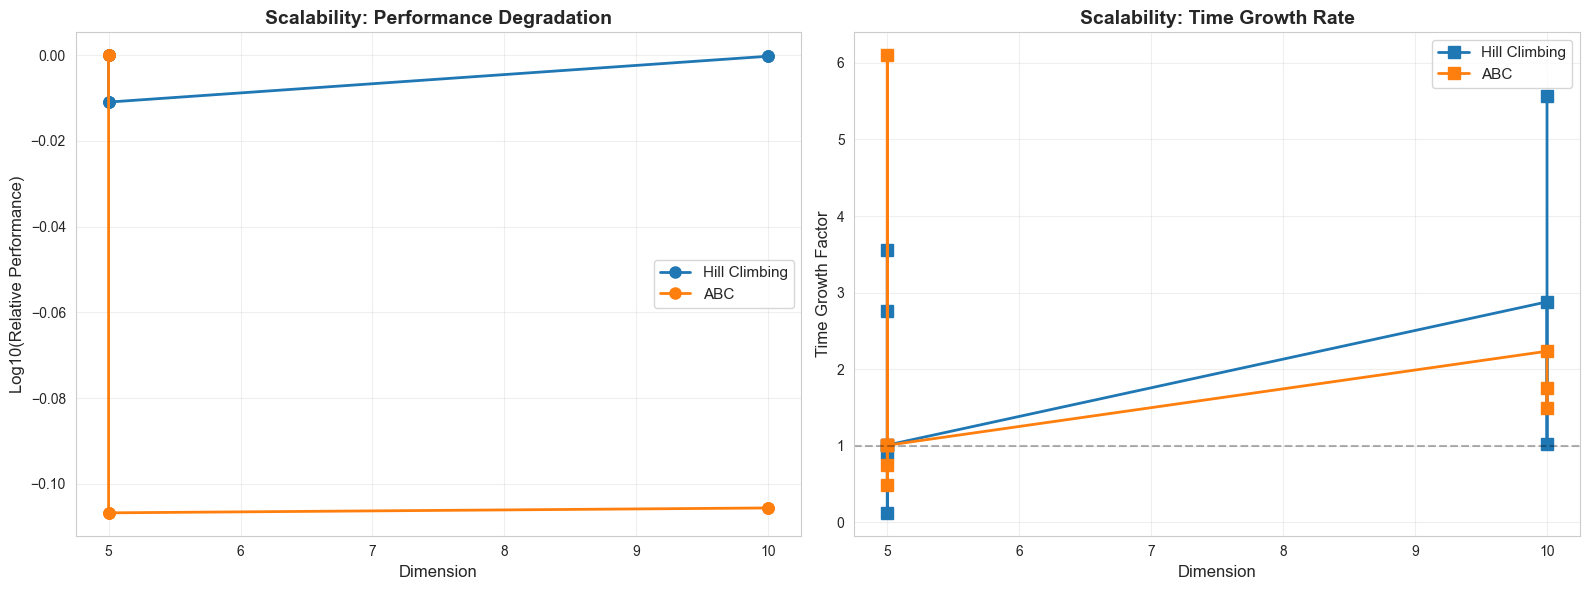

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    if len(algo_data) > 1:
        # Use log-scale ratio to avoid division by near-zero
        base_value = algo_data.iloc[0]["Best Value"]
        # Compute ratio in log space for stability
        log_ratio = np.log10(algo_data["Best Value"] + 1e-10) - np.log10(
            base_value + 1e-10
        )
        ax1.plot(
            algo_data["Dimension"],
            log_ratio,
            marker="o",
            label=algo,
            linewidth=2,
            markersize=8,
        )

ax1.set_xlabel("Dimension", fontsize=12)
ax1.set_ylabel("Log10(Relative Performance)", fontsize=12)
ax1.set_title("Scalability: Performance Degradation", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
for algo in all_results["Algorithm"].unique():
    algo_data = all_results[all_results["Algorithm"] == algo].sort_values("Dimension")
    if len(algo_data) > 1:
        time_ratios = []
        dims = []
        for i in range(1, len(algo_data)):
            ratio = (
                algo_data.iloc[i]["Mean Time (s)"]
                / algo_data.iloc[i - 1]["Mean Time (s)"]
            )
            time_ratios.append(ratio)
            dims.append(algo_data.iloc[i]["Dimension"])
        ax2.plot(dims, time_ratios, marker="s", label=algo, linewidth=2, markersize=8)

ax2.axhline(y=1, color="black", linestyle="--", alpha=0.3)
ax2.set_xlabel("Dimension", fontsize=12)
ax2.set_ylabel("Time Growth Factor", fontsize=12)
ax2.set_title("Scalability: Time Growth Rate", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Statistical Summary

In [ ]:
summary_stats = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": ["mean", "std", "min"],
            "Mean Value": ["mean", "std"],
            "Mean Time (s)": ["mean", "std"],
            "Evaluations": ["mean"],
        }
    )
    .round(6)
)

print("\n" + "=" * 100)
print("COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 100)
print(summary_stats)

ranking_metrics = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

ranking_metrics["Quality Rank"] = ranking_metrics["Best Value"].rank(ascending=True)
ranking_metrics["Speed Rank"] = ranking_metrics["Mean Time (s)"].rank(ascending=True)
ranking_metrics["Robustness Rank"] = ranking_metrics["Std Value"].rank(ascending=True)
ranking_metrics["Overall Rank"] = (
    ranking_metrics["Quality Rank"]
    + ranking_metrics["Speed Rank"]
    + ranking_metrics["Robustness Rank"]
) / 3

print("\n" + "=" * 100)
print("ALGORITHM RANKINGS")
print("=" * 100)
print(
    ranking_metrics[
        ["Algorithm", "Quality Rank", "Speed Rank", "Robustness Rank", "Overall Rank"]
    ].to_string(index=False)
)


COMPREHENSIVE STATISTICAL SUMMARY
              Best Value                      Mean Value            \
                    mean       std        min       mean       std   
Algorithm                                                            
ABC             0.000000  0.000000   0.000000    0.00000  0.000000   
Hill Climbing  18.729456  0.224613  18.404026   19.83316  0.239964   

              Mean Time (s)           Evaluations  
                       mean       std        mean  
Algorithm                                          
ABC                0.519762  0.454822     10300.0  
Hill Climbing      0.015200  0.019932       637.9  

ALGORITHM RANKINGS
    Algorithm  Quality Rank  Speed Rank  Robustness Rank  Overall Rank
          ABC           1.0         2.0              1.0      1.333333
Hill Climbing           2.0         1.0              2.0      1.666667


## 7. Radar Chart Comparison

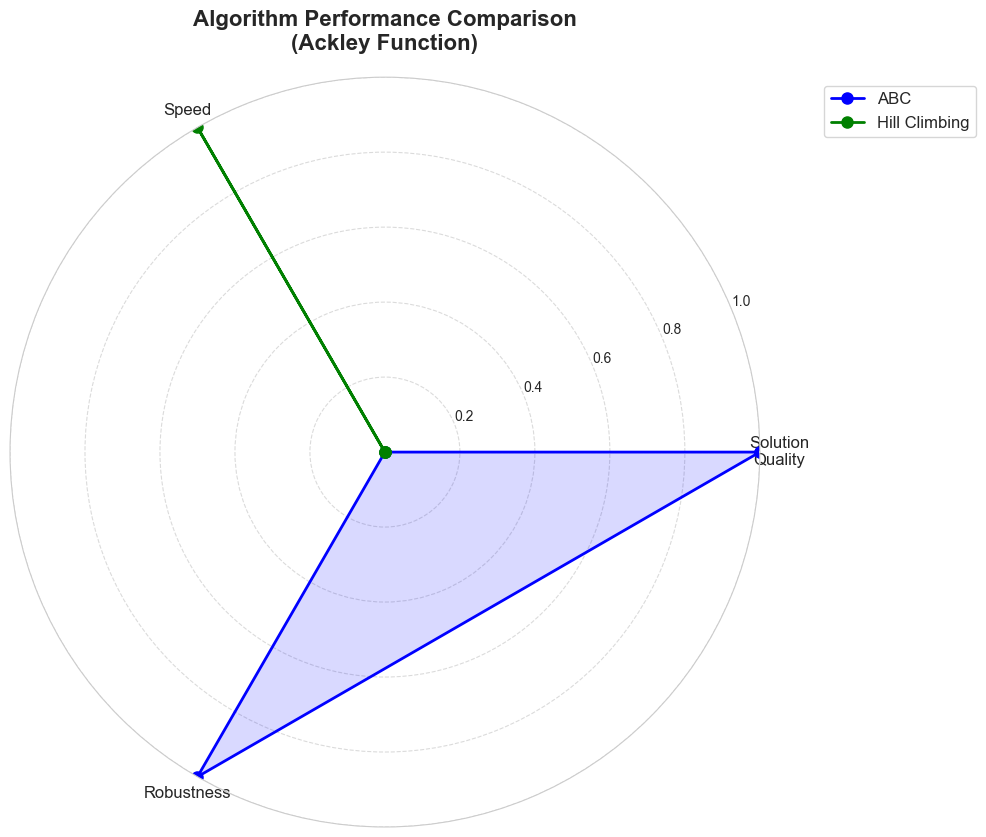

In [ ]:
def normalize_metric(values, higher_is_better=True):
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values)
    normalized = (values - min_val) / (max_val - min_val)
    return normalized if higher_is_better else 1 - normalized


radar_data = (
    all_results.groupby("Algorithm")
    .agg(
        {
            "Best Value": "mean",
            "Mean Time (s)": "mean",
            "Std Value": "mean",
        }
    )
    .reset_index()
)

radar_data["Quality_norm"] = normalize_metric(radar_data["Best Value"].values, False)
radar_data["Speed_norm"] = normalize_metric(radar_data["Mean Time (s)"].values, False)
radar_data["Robustness_norm"] = normalize_metric(radar_data["Std Value"].values, False)

categories = ["Solution\nQuality", "Speed", "Robustness"]
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))
colors = ["blue", "green"]

for idx, row in radar_data.iterrows():
    values = [row["Quality_norm"], row["Speed_norm"], row["Robustness_norm"]]
    values += values[:1]
    ax.plot(
        angles,
        values,
        "o-",
        linewidth=2,
        label=row["Algorithm"],
        color=colors[idx],
        markersize=8,
    )
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_title(
    "Algorithm Performance Comparison\n(Ackley Function)",
    size=16,
    fontweight="bold",
    pad=20,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=12)

plt.tight_layout()
plt.show()